In [1]:
import csv
import random
import string
import time
import numpy as np

npap = 28
nrev = 31

paper_names = ["Making Machine Learning Fair",
"Interpreting AI Decision-Making",
"Transparent Machine-Learning Models",
"Voting for Participatory Budgeting",
"Voting with Delegation",
"Improved Learning from Rankings",
"Equilibrium Selection in Cooperative Games",
"Communication for Teamwork in Games",
"Multi-Agent Cooperative Board Games",
"An Overview of Zero-Sum Games",
"Solution Concepts in Many-Player Games",
"Stackelberg Security Games for Coastal Defense",
"A No-Regret Algorithm for Efficient Equilibrium Computation",
"Consistency of Bayesian Inference",
"Fitting Graphical Models",
"A Novel Gaussian Process Approximation",
"A*+DFS: A Hybrid Search Algorithm",
"A* Search Under Uncertainty",
"Search-Based Planning of Robot Trajectories",
"Online Convex Optimization with Regularization",
"Private Stochastic Convex Optimization",
"A Hybrid Method for Non-Convex Optimization",
"Memory and Computation-Efficient Kernel SVMs",
"Forecasting Stock Prices with Deep Learning",
"A Deep Learning Approach for Anomaly Detection",
"New Algorithms for 3D Computer Vision",
"Towards More Accurate NLP Models",
"Optimal Error Bounds in Statistical Learning Theory"]

subject_area_names = ["Humans and AI: Fairness",
"Humans and AI: Interpretability, accountability, and transparency in AI",
"Social choice theory: Voting rules",
"Social choice theory: Ranking models",
"Social choice theory: Mechanism design",
"Game theory: Cooperative games",
"Game theory: Non-cooperative games",
"Game theory: Stackelberg security games",
"Game theory: No-regret learning",
"Probabilistic modeling: Bayesian theory",
"Probabilistic modeling: Graphical models",
"Probabilistic modeling: Gaussian processes",
"Probabilistic modeling: Topic models",
"Search: A* algorithms and variants",
"Search: Robotics applications of search",
"Optimization: Integer programming",
"Optimization: Linear programming",
"Optimization: Convex optimization",
"Optimization: Non-convex optimization",
"Machine learning: Classical machine learning (SVM, kernel methods)",
"Machine learning: Deep learning",
"Machine learning: Computer vision",
"Machine learning: Natural language processing",
"Machine learning: Bias-complexity tradeoffs and double descent curves",
"Machine learning: Learning theory"]
l1_subject_area_names = ["Humans and AI", "Social choice theory", 
                         "Game theory", "Probabilistic modeling", 
                         "Search", "Optimization", "Machine learning"]

def l2_to_l1(l2):
    return l1_subject_area_names.index(subject_area_names[l2].split(":")[0])
def l1_to_l2(l1):
    return {i for i, name in enumerate(subject_area_names) 
            if name.split(":")[0] == l1_subject_area_names[l1]
           }

In [2]:
email_to_id = {}
paper_to_id = {}
HB = np.zeros((nrev, npap)) # (reviewers, papers) with entries in {-1, 0, 1}
MB = np.zeros((nrev, npap)) # (reviewers, papers) with entries in {-1, 0, 1}

with open('anonymize/anonymize_malicious_bidding.csv') as csvfile:
    csv_reader = csv.reader(csvfile)
    header = next(csv_reader)
    bid_start_idx = 1
    assert(header[0] == 'RecipientEmail' and header[bid_start_idx] == 'Q3_1' and 
           header[bid_start_idx + npap - 1] == 'Q3_28')
    header = next(csv_reader)
    assert header[0] == 'Recipient Email'
    for paper_id, paper in enumerate(header[bid_start_idx:bid_start_idx+npap]):
        paper_name = paper[paper.find(': -') + 3:].strip()
        paper_to_id[paper_name] = paper_id
    reviewer_id = 0
    for row in csv_reader:
        email_to_id[row[0]] = reviewer_id
        for paper_id in range(npap):
            if row[bid_start_idx + paper_id] == 'Not willing to review':
                MB[reviewer_id, paper_id] = -1
            elif row[bid_start_idx + paper_id] == 'Indifferent':
                MB[reviewer_id, paper_id] = 0
            elif row[bid_start_idx + paper_id] == 'Eager to review':
                MB[reviewer_id, paper_id] = 1
        reviewer_id += 1
    assert reviewer_id == nrev, reviewer_id

with open('anonymize/anonymize_honest_bidding.csv') as csvfile:
    csv_reader = csv.reader(csvfile)
    header = next(csv_reader)
    assert(header[0] == 'RecipientEmail' and header[bid_start_idx] == 'Q3_1' and 
           header[bid_start_idx + npap - 1] == 'Q3_28')
    header = next(csv_reader)
    assert header[0] == 'Recipient Email'
    for row in csv_reader:
        if row[0] not in email_to_id: # did not submit malicious bids
            continue
        reviewer_id = email_to_id[row[0]]
        for paper_id in range(npap):
            if row[bid_start_idx + paper_id] == 'Not willing to review':
                HB[reviewer_id, paper_id] = -1
            elif row[bid_start_idx + paper_id] == 'Indifferent':
                HB[reviewer_id, paper_id] = 0
            elif row[bid_start_idx + paper_id] == 'Eager to review':
                HB[reviewer_id, paper_id] = 1
                
strategy_map = {}
with open('anonymize/malicious_bidding_annotations.csv') as csvfile:
    csv_reader = csv.reader(csvfile)
    header = next(csv_reader)
    for row in csv_reader:
        if row[0] not in email_to_id: # did not submit malicious bids
            continue
        reviewer_id = email_to_id[row[0]]
        strat = row[1]
        if strat == '?':
            strat = -1
        else:
            strat = int(strat)
        strategy_map[reviewer_id] = strat

In [3]:
reviewer_to_sas = {} # dict of review -> list of subject areas
reviewer_to_group = {} # dict of reviewer -> group id
reviewer_to_sa = {} # dict of review -> subject area of authored paper
sa_to_paper_ids = {} # dict of subject area -> list of papers in the subject area
paper_to_sa = {} # dict of paper -> subject area
group_to_targets = {} # dict of group -> list of target papers

SA = np.zeros(HB.shape) # (reviewers, papers) with entries in {0, 1}
group_map = {} # dict of group id -> list of reviewer indices in that group
author_map = {} # dict of reviewer -> index of paper authored
target_map = {} # dict of reviewer -> index of target paper (for reviewers with group size 1)
author_map_group = {} # dict of reviewer -> indices of target papers (including other team members' authored papers)

with open('anonymize/anonymize_setup.csv') as csvfile:
    r = csv.reader(csvfile)
    header = next(r)
    assert(all([x == y for x, y in 
        zip(header, ['name', 'sas', 'authored_sa', 'authored_id', 'target_sa', 'target_id', 'group'])
        ]))
    for row in r:
        if row[0] in email_to_id:
            reviewer_id = email_to_id[row[0]]
        else:
            reviewer_id = -1
        
        sas = {int(x) for x in row[1].strip().split(' ')}
        sa_id = int(row[2]) 
        paper_id = paper_to_id[paper_names[int(row[3])]] # paper_id is based on position in survey
        
        paper_to_sa[paper_id] = sa_id
        if sa_id in sa_to_paper_ids:
            sa_to_paper_ids[sa_id].add(paper_id)
        else:
            sa_to_paper_ids[sa_id] = {paper_id}
        
        if reviewer_id >= 0:
            reviewer_to_sas[reviewer_id] = sas
            reviewer_to_sa[reviewer_id] = sa_id
            author_map[reviewer_id] = paper_id 
            
            group = int(row[6])
            if group in group_map:
                group_map[group].append(reviewer_id)
            else:
                group_map[group] = [reviewer_id]
            reviewer_to_group[reviewer_id] = group
            if len(row[5]) > 0: 
                target_id = paper_to_id[paper_names[int(row[5])]]
                target_map[reviewer_id] = target_id
        
        group = int(row[6])
        if group in group_to_targets:
            group_to_targets[group].append(paper_id)
        else:
            group_to_targets[group] = [paper_id]
            
# compute SA matrix
for reviewer_id in range(len(reviewer_to_sas)):
    l2_sas = reviewer_to_sas[reviewer_id]
    l1_sas = {l2_to_l1(x) for x in l2_sas}
    # set matching L1 to 0.5
    for l1_sa in l1_sas:
        for sa_id in l1_to_l2(l1_sa): # some SAs don't have papers
            if sa_id not in sa_to_paper_ids:
                continue
            for paper_id in sa_to_paper_ids[sa_id]:
                SA[reviewer_id, paper_id] = 0.5
    # set matching L2 to 1 (overwriting)
    for sa_id in l2_sas:
        for paper_id in sa_to_paper_ids[sa_id]: 
            SA[reviewer_id, paper_id] = 1
print(np.sum(SA == 1), np.sum(SA == 0.5), np.sum(SA == 0))

for reviewer_id in range(len(reviewer_to_group)):
    author_map_group[reviewer_id] = group_to_targets[reviewer_to_group[reviewer_id]]

142 168 558


In [4]:
import pickle

np.savez('analysis/Biddings.npz', HB=HB, MB=MB, SA=SA)
#with open('analysis/Biddings.npy', 'wb') as f: # change to npz dict?
#    np.save(f, HB)
#    np.save(f, MB)
#    np.save(f, SA)

with open('analysis/maps.pkl', 'wb') as f:
    pickle.dump({
        'author_map' : author_map, 
        'group_map' : group_map, 
        'target_map' : target_map, 
        'author_map_group' : author_map_group, 
        'authored_sa_map' : reviewer_to_sa,
        'reviewer_to_sas' : reviewer_to_sas,
        'paper_to_sas' : paper_to_sa
    }, f)
#    pickle.dump(group_map, f)
#    pickle.dump(target_map, f)
#    pickle.dump(author_map_group, f)


[6. 3. 9. 2. 4. 2.]


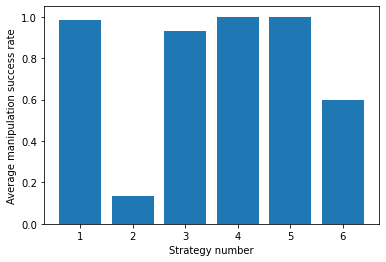

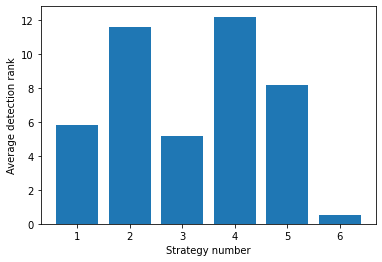

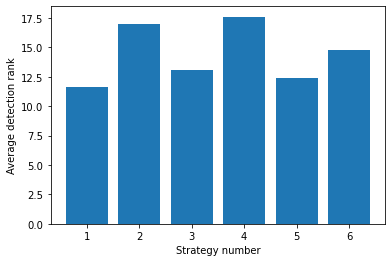

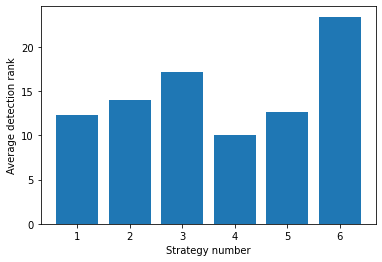

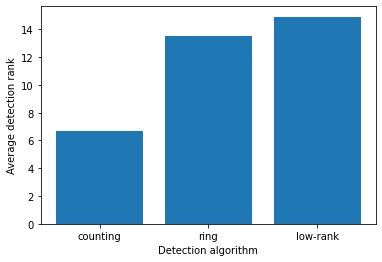

In [27]:
'''
Strategy annotation key:
1 Basic: Eager to a mixed set of target and non-group papers (6)
2 Eager to same set of non-group papers: Eager to a mixed set of target and non-group papers; eager to a shared set of non-group papers to push them to be full, thus not assigned to colluding members (3)
3 Indifferent to similar: Eager to a mixed set of target and non-group papers; indifferent to similar non-group papers (9)
4 Not willing to similar: Eager to a mixed set of target and non-group papers; not willing to similar non-group papers (2)
5 Eager cycle within group: Eager to a mixed set of target and non-group papers; make an eager cycle within a group (4)
6 Indifferent to popular, eager to unpopular: Eager to a mixed set of target and non-group papers; indifferent to likely popular target papers; eager to likely unpopular target papers (2)
'''

with open('analysis/Result.npy', 'rb') as f: # analysis done in other script
    success_by_reviewer = np.load(f)
    rank_by_reviewer_simple = np.load(f)
    rank_by_reviewer_cluster = np.load(f)
    rank_by_reviewer_lowrank = np.load(f)
    #diff_by_reviewer_hamming = np.load(f)
    #diff_by_reviewer_L1 = np.load(f)

'''
email_list = list(email_to_id.keys())
reviewer_id_list = list(email_to_id.values())
     
with open('analysis/Result.csv', 'w', newline='') as csvfile:
    column_names = ['Email', 'Group_id', 'Collaborators', 'Success_rate', 'Rank_simple', \
                   'Rank_cluster', 'Rank_low_rank', 'Diff_hamming', 'Diff_L1']
    csv_writer = csv.DictWriter(csvfile, fieldnames=column_names)
    csv_writer.writeheader()
    for reviewer_idx in range(success_by_reviewer.shape[0]):
        row = {}
        row['Email'] = email_list[reviewer_id_list.index(reviewer_idx)]
        row['Group_id'] = reviewer_to_group[reviewer_idx]
        row['Collaborators'] = group_map[row['Group_id']]
        row['Success_rate'] = success_by_reviewer[reviewer_idx]
        row['Rank_simple'] = rank_by_reviewer_simple[reviewer_idx]
        row['Rank_cluster'] = rank_by_reviewer_cluster[reviewer_idx]
        row['Rank_low_rank'] = rank_by_reviewer_lowrank[reviewer_idx]
        #row['Diff_hamming'] = diff_by_reviewer_hamming[reviewer_idx]
        #row['Diff_L1'] = diff_by_reviewer_L1[reviewer_idx]
        csv_writer.writerow(row)
'''

# Plot results 
import matplotlib.pyplot as plt

strategy_success = np.zeros(6)
strategy_count = np.zeros(6)
strategy_rank_simple = np.zeros(6)
strategy_rank_cluster = np.zeros(6)
strategy_rank_lowrank = np.zeros(6)
rank_total = np.zeros(3)
for r in range(success_by_reviewer.size):
    strat = strategy_map[r] - 1
    if strat < 0:
        continue
    strategy_count[strat] += 1
    strategy_success[strat] += success_by_reviewer[r]
    strategy_rank_simple[strat] += rank_by_reviewer_simple[r]
    strategy_rank_cluster[strat] += rank_by_reviewer_cluster[r]
    strategy_rank_lowrank[strat] += rank_by_reviewer_lowrank[r]
    rank_total += np.array([rank_by_reviewer_simple[r], rank_by_reviewer_cluster[r], rank_by_reviewer_lowrank[r]])
    
strategy_success /= strategy_count
strategy_rank_simple /= strategy_count
strategy_rank_cluster /= strategy_count
strategy_rank_lowrank /= strategy_count
rank_total /= np.sum(strategy_count)
print(strategy_count)

# TODO larger text, strategy labels
plt.bar(np.arange(1, 7), strategy_success)
plt.ylabel('Average manipulation success rate')
plt.xlabel('Strategy number')
plt.savefig('success.pdf')
plt.show()

plt.bar(np.arange(1, 7), strategy_rank_simple)
plt.ylabel('Average detection rank')
plt.xlabel('Strategy number')
plt.savefig('rank_simple.pdf')
plt.show()

plt.bar(np.arange(1, 7), strategy_rank_cluster)
plt.ylabel('Average detection rank')
plt.xlabel('Strategy number')
plt.savefig('rank_cluster.pdf')
plt.show()

plt.bar(np.arange(1, 7), strategy_rank_lowrank)
plt.ylabel('Average detection rank')
plt.xlabel('Strategy number')
plt.savefig('rank_lowrank.pdf')
plt.show()

plt.bar(np.arange(3), rank_total)
plt.xticks(np.arange(3), ['counting', 'ring', 'low-rank'])
plt.ylabel('Average detection rank')
plt.xlabel('Detection algorithm')
plt.savefig('rank_algos.pdf')
plt.show()

In [10]:
def count(li_):
    li = list(li_)
    ctr = {}
    for x in li:
        sa_string = subject_area_names[x].split(':')[0]
        if sa_string not in ctr:
            ctr[sa_string] = 1
        else:
            ctr[sa_string] += 1
    return ctr
    
'''
def count(li_): # count number of papers in each subject area
    li = list(li_)
    ctr = [0, 0, 0, 0, 0, 0, 0]
    for x in li:
        if 0 <= x < 2:
            ctr[0] += 1
        if 2 <= x < 5:
            ctr[1] += 1
        if 5 <= x < 9:
            ctr[2] += 1
        if 9 <= x < 13:
            ctr[3] += 1
        if 13 <= x < 15:
            ctr[4] += 1
        if 15 <= x < 19:
            ctr[5] += 1
        if 19 <= x < 25:
            ctr[6] += 1
    return ctr
'''

print(count(reviewer_to_sa.values()))
print(count(paper_to_sa.values()))
#print(group_to_targets)

{'Game theory': 10, 'Humans and AI': 3, 'Social choice theory': 5, 'Optimization': 2, 'Search': 3, 'Probabilistic modeling': 3, 'Machine learning': 5}
{'Probabilistic modeling': 3, 'Game theory': 7, 'Humans and AI': 3, 'Optimization': 3, 'Social choice theory': 3, 'Machine learning': 6, 'Search': 3}
